In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
from pylinger_cosmo import cosmo
import pylinger_thermo as pthermo
from pylinger_pt import pt_synchronous

In [3]:
cp = cosmo(Omegam=0.3, Omegab=0.045, OmegaL=0.7, H0=67.0, Tcmb=2.726, YHe=0.24 )

In [4]:
th = pthermo.thermal_history(taumin=cp.tau[1],taumax=cp.tau[-1],cp=cp,N=1000)

In [5]:
pt = pt_synchronous(cp=cp,th=th)

In [6]:
kmodes = np.geomspace(1e-4,1e0,100)
y,t = pt.compute(kmodes = kmodes, aexp_out=np.geomspace(1e-4,1e-2,2))#,rtol=1e-6)#, rtol=1e-9, atol = 1e-10)

43.29291833797096 1377.6029215658377
Omegam = 0.3


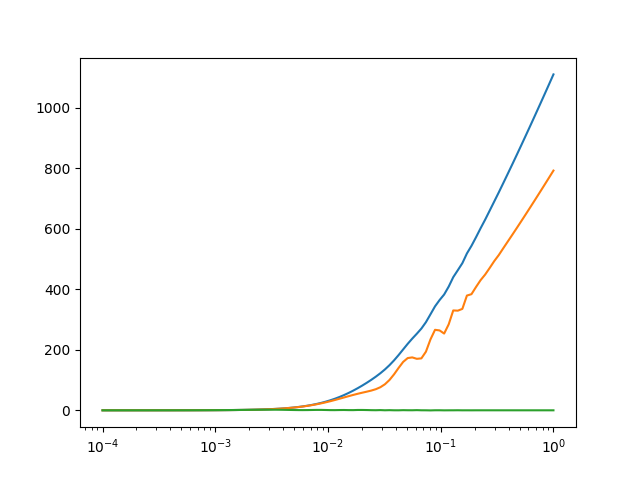

In [8]:
fig, ax = plt.subplots()

iout=1

ax.semilogx( kmodes, y[:,3,iout])
ax.semilogx( kmodes, y[:,5,iout])
ax.semilogx( kmodes, y[:,7,iout])

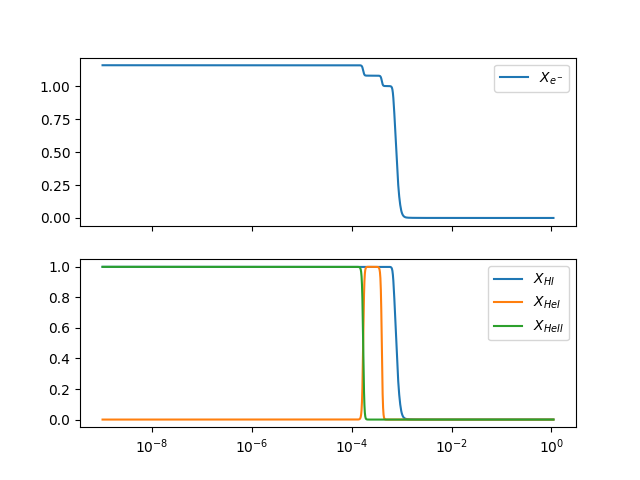

In [8]:
fg, ax = plt.subplots(2,sharex=True)
ax[0].semilogx( cp.get_a(th.tau), th.xe, label='$X_{e^-}$' )
ax[1].semilogx( cp.get_a(th.tau), th.xH, label='$X_{HI}$' )
ax[1].semilogx( cp.get_a(th.tau), th.xHeI, label='$X_{HeI}$' )
ax[1].semilogx( cp.get_a(th.tau), th.xHeII, label='$X_{HeII}$' )
for a in ax: a.legend()

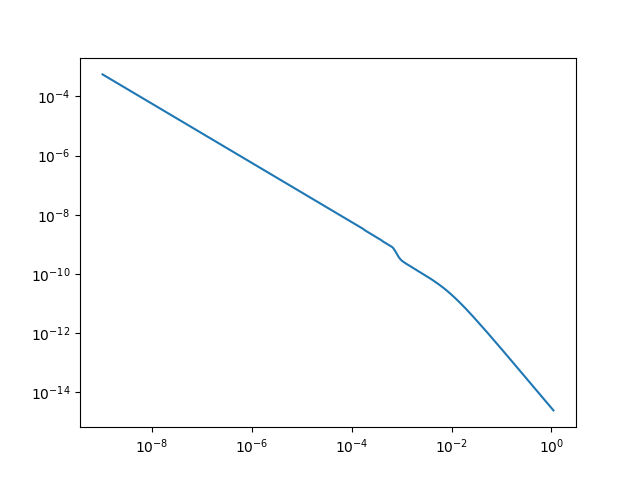

In [9]:
fig, ax = plt.subplots()
ax.loglog( cp.get_a(th.tau), th.cs2, label='$X_{e^-}$' )